In [1]:
import glob
import os
import re

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import calliope
from calliope.core.util.dataset import split_loc_techs

In [2]:
scenarios = {
    'link_cap_500x': 'up to 500x', 
    'link_cap_5x': 'up to 5x', 
    'link_cap_1x': 'fixed current', 
    'link_cap_100x': 'up to 100x',
    'link_cap_20': 'up to 20GW', 
    'link_cap_dynamic': 'Dynamic maximum', 
    'link_cap_10x': 'up to 10x', 
    'link_cap_2x': 'up to 2x',
    'link_cap_50x': 'up to 50x',
    'link_cap_10_40': 'up to 10GW (DC), 40GW (AC)', 
    'link_cap_40': 'up to 40GW',
    'baseline': 'no_limit'
}
scenario_order = ['no_limit', 'fixed current', 'up to 2x', 'up to 5x', 'up to 10x', 'up to 50x', 'up to 100x', 'up to 500x', 'Dynamic maximum', 'up to 20GW', 'up to 40GW', 'up to 10GW (DC), 40GW (AC)']

In [3]:
calliope.set_log_verbosity()

In [5]:
baseline_model = calliope.read_netcdf("../outputs/model_out_3h.nc")

model_filenames = glob.glob("../outputs/link_cap*.nc")
model_dict = {'baseline': baseline_model._model_data, **{
    os.path.basename(model_filename).split('.')[0]: calliope.read_netcdf(model_filename)._model_data 
    for model_filename in model_filenames
}}
scenario_model_data = xr.concat(model_dict.values(), dim=pd.Index(model_dict.keys(), name='scenario'))

[2021-01-25 16:20:45] INFO     Model: initialising
[2021-01-25 16:21:20] INFO     Model: loaded model_data
[2021-01-25 16:21:28] INFO     Model: initialising
[2021-01-25 16:22:04] INFO     Model: loaded model_data
[2021-01-25 16:22:12] INFO     Model: initialising
[2021-01-25 16:22:48] INFO     Model: loaded model_data
[2021-01-25 16:22:58] INFO     Model: initialising
[2021-01-25 16:23:35] INFO     Model: loaded model_data
[2021-01-25 16:23:45] INFO     Model: initialising
[2021-01-25 16:24:20] INFO     Model: loaded model_data
[2021-01-25 16:24:28] INFO     Model: initialising
[2021-01-25 16:25:04] INFO     Model: loaded model_data
[2021-01-25 16:25:11] INFO     Model: initialising
[2021-01-25 16:25:46] INFO     Model: loaded model_data
[2021-01-25 16:25:56] INFO     Model: initialising
[2021-01-25 16:26:30] INFO     Model: loaded model_data
[2021-01-25 16:26:42] INFO     Model: initialising
[2021-01-25 16:27:17] INFO     Model: loaded model_data
[2021-01-25 16:27:25] INFO     Model:

In [6]:
energy_cap = split_loc_techs(scenario_model_data.energy_cap, return_as='Series')

In [88]:
energy_cap_df = energy_cap.dropna().filter(regex='transmission').reset_index()
energy_cap_df['techs'] = energy_cap_df['techs'].str.split('_', expand=True)[0]
energy_cap_df['scenario'] = energy_cap_df['scenario'].map(scenarios)
energy_cap_df['energy_cap'] *= 100

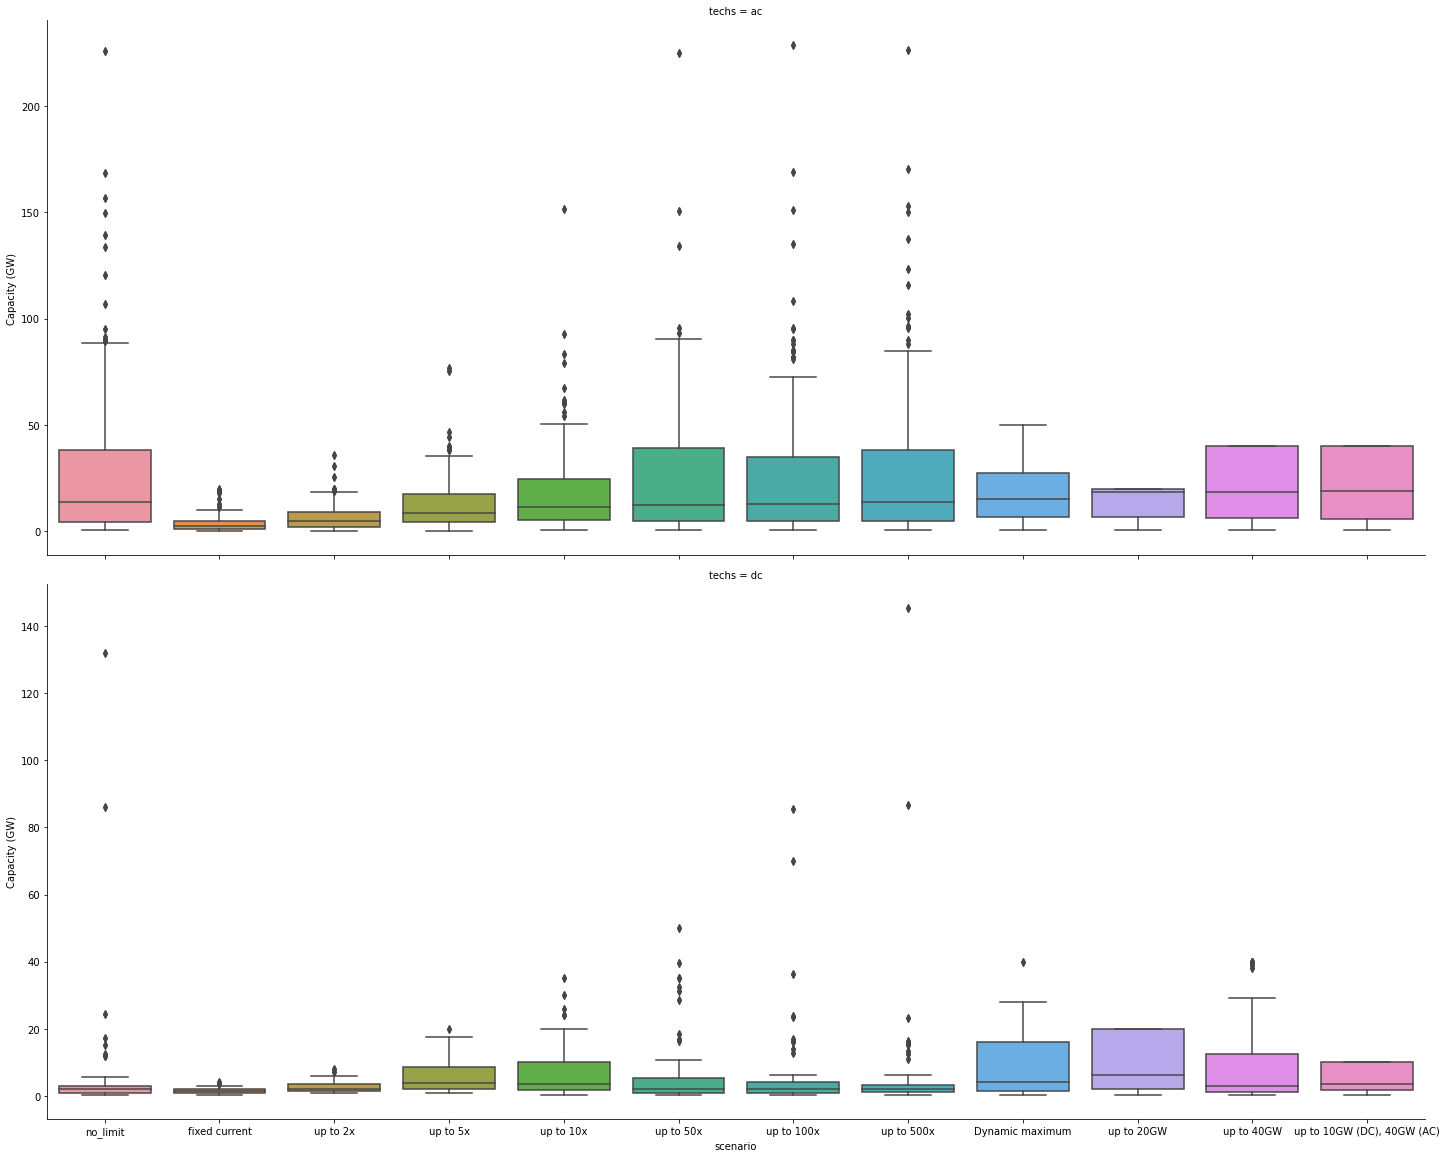

In [89]:
#fig, ax = plt.subplots(1, 1, figsize=(20, 15))
fg = sns.catplot(data=energy_cap_df, x='scenario', y='energy_cap', col='techs', col_wrap=1, kind='box', height=8, aspect=2.5, order=scenario_order, sharey=False)
for ax in fg.axes:
    ax.set_ylabel('Transmission capacity (GW)')

In [97]:
energy_cap_renewables = energy_cap.where(lambda x: x > 1e-5).dropna().filter(regex='pv|wind').reset_index()

In [98]:
energy_cap_renewables['scenario'] = energy_cap_renewables['scenario'].map(scenarios)
energy_cap_renewables['energy_cap'] *= 100

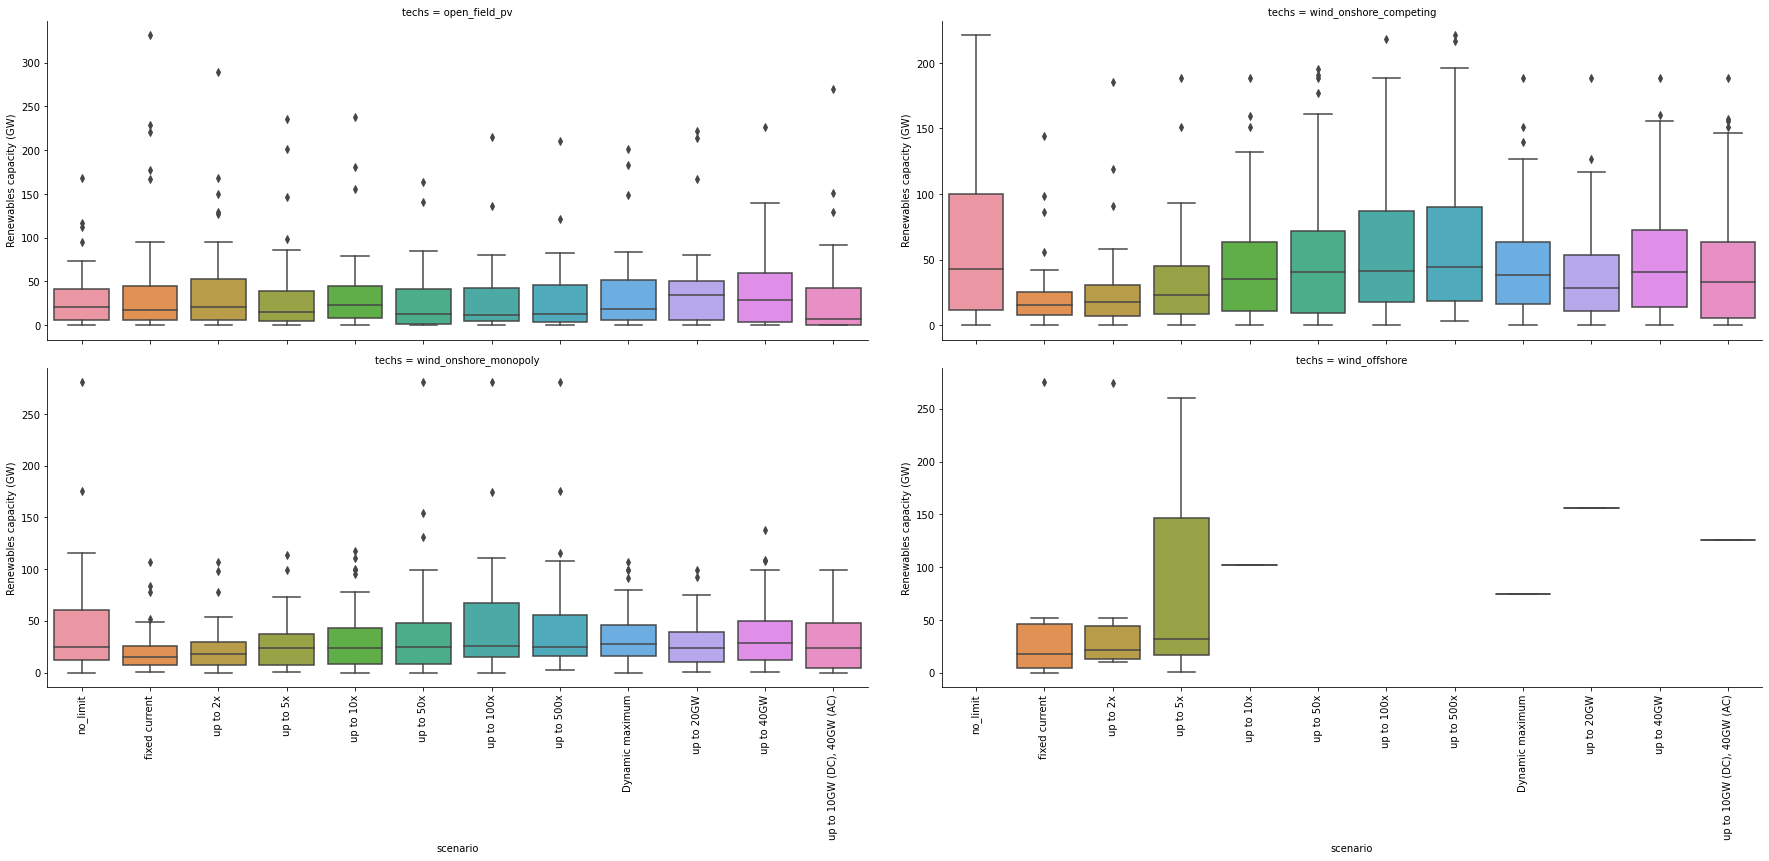

In [101]:
fg = sns.catplot(data=energy_cap_renewables, x='scenario', y='energy_cap', col='techs', col_wrap=2, kind='box', height=5, aspect=2.5, order=scenario_order, sharey=False)
for ax in fg.axes:
    ax.set_ylabel('Renewables capacity (GW)')
fg.set_xticklabels(rotation=90)

In [7]:
tech_groups = {
    'ac_ohl_mountain_transmission': 'transmission',
    'ac_ohl_transmission': 'transmission',
    'battery': 'storage',
    'dc_ohl_transmission': 'transmission',
    'dc_subsea_transmission': 'transmission',
    'dc_underground_transmission': 'transmission',
    'hydro_reservoir': 'hydro',
    'hydro_run_of_river': 'hydro',
    'hydrogen_storage': 'storage',
    'open_field_pv': 'pv',
    'pumped_hydro': 'storage',
    'roof_mounted_pv': 'pv',
    'wind_offshore': 'wind_off',
    'wind_onshore_competing': 'wind_on',
    'wind_onshore_monopoly': 'wind_on',
    'electrolysis': 'electrolysis'
}

In [41]:
energy_cap_sum = energy_cap.dropna().sum(level=['scenario', 'techs']).reset_index()
energy_cap_sum['techs'] = energy_cap_sum['techs'].str.split(':', expand=True)[0]
energy_cap_sum = energy_cap_sum.loc[energy_cap_sum.techs.isin(tech_groups.keys())]
energy_cap_sum['techs'] = energy_cap_sum['techs'].map(tech_groups)
energy_cap_sum = energy_cap_sum.groupby(['scenario', 'techs']).sum()
max_caps = energy_cap_sum.groupby(level='techs').max()
energy_cap_sum = energy_cap_sum.div(max_caps).reset_index()
max_caps.loc['transmission'] /= 2
energy_cap_sum['scenario'] = energy_cap_sum['scenario'].map(scenarios)

[2021-01-25 16:39:53] WARNING  /cluster/work/apatt/brynmorp/miniconda/envs/eurocalliope/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning:

FixedFormatter should only be used together with FixedLocator




[Text(0, 0, 'electrolysis\nMax: 595.13 GW'),
 Text(1, 0, 'hydro\nMax: 53.84 GW'),
 Text(2, 0, 'pv\nMax: 2556.69 GW'),
 Text(3, 0, 'storage\nMax: 351.36 GW'),
 Text(4, 0, 'transmission\nMax: 5255.53 GW'),
 Text(5, 0, 'wind_off\nMax: 457.06 GW'),
 Text(6, 0, 'wind_on\nMax: 4213.06 GW')]

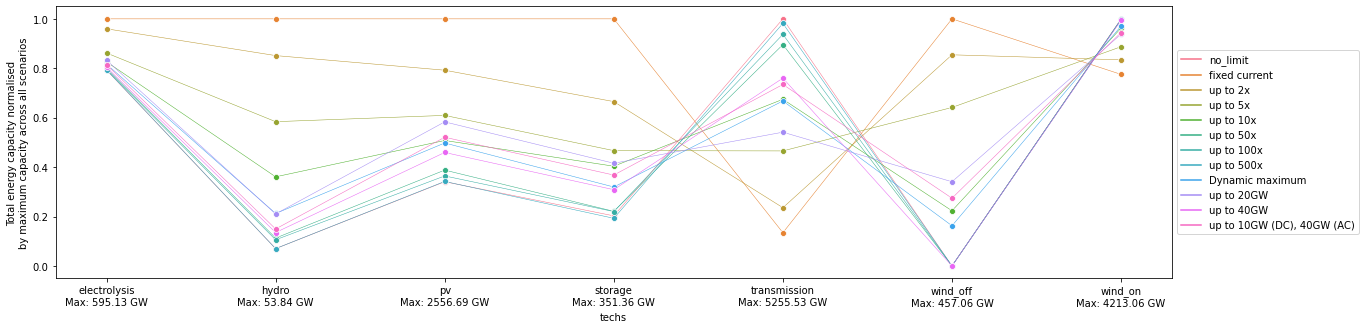

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.lineplot(data=energy_cap_sum, x='techs', y='energy_cap', hue='scenario', ax=ax, marker='o', lw=0.5, hue_order=scenario_order)
xlabels = ["{}\nMax: {:.2f} GW".format(tech, max_caps.loc[tech].energy_cap * 100) for tech in energy_cap_sum.techs.unique()]
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Total energy capacity normalised\nby maximum capacity across all scenarios')

ax.set_xticklabels(xlabels)